In [5]:
import scipy.io

# scipy.io.loadmat funktioniert nur für MATLAB-Dateien bis Version 7.2.

# Deine Datei ist aber in Version 7.3 gespeichert (HDF5-basiert) – deshalb kommt:



# Haward

In [84]:
import scipy.io

# Datei laden
data = scipy.io.loadmat("haward.mat")

# Alle enthaltenen Variablennamen anzeigen

print(data.keys())


dict_keys(['__header__', '__version__', '__globals__', 'ref', 'lbl'])


### Reinschauen

In [85]:
import matplotlib.pyplot as plt


# ref	Reflektanzdaten – ein 3D-Array (z. B. Bänder × Höhe × Breite)
# lbl	Labels / Ground Truth – z. B. Materialklassen, Segmentierungen etc. 
# Label-Matrix – jedes Pixel hat eine Klasse

# Formate anzeigen
print("ref:", data['ref'].shape)
print("lbl:", data['lbl'].shape)

ref: (1040, 1392, 31)
lbl: (1040, 1392)


### Einzelnes Band anzeigen

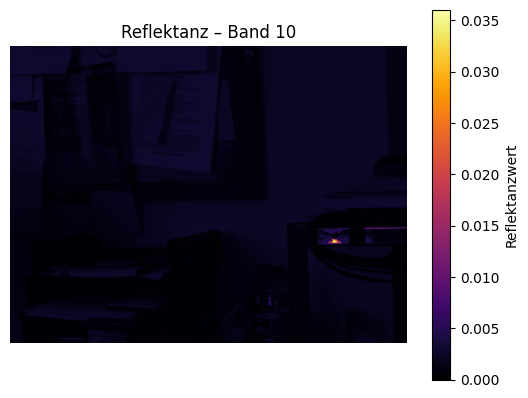

In [86]:
import matplotlib.pyplot as plt

band_index = 10  # z. B. das 11. Band (Index beginnt bei 0)
ref_img = data['ref'][:, :, band_index]  # (H, W) extrahieren

plt.imshow(ref_img,  cmap='inferno')
plt.title(f"Reflektanz – Band {band_index}")
plt.colorbar(label="Reflektanzwert")
plt.axis('off')
plt.show()

### Labels anzeigen (Ground Truth)

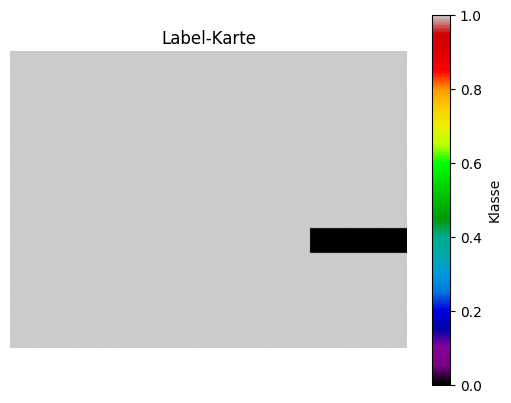

In [62]:
label_img = data['lbl']

plt.imshow(label_img, cmap='nipy_spectral')  # für bunte, getrennte Klassen
plt.title("Label-Karte")
plt.colorbar(label="Klasse")
plt.axis('off')
plt.show()

# HADAR


In [65]:
import scipy.io

# Datei laden
data = scipy.io.loadmat("hadar_cube.mat")

# Alle enthaltenen Variablennamen anzeigen

print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'S'])


### So prüfst du, was S genau ist:

In [66]:
# 	Wahrscheinlich ein Hyperspektralbild mit 54 Spektralbändern (z. B. Reflektanz oder Strahlung) pro Pixel

import numpy as np

S = data['S']
print("Shape:", S.shape)
print("Dtype:", S.dtype)
print("Min:", S.min(), "Max:", S.max())

Shape: (1080, 1920, 54)
Dtype: float32
Min: 0.032958984 Max: 0.20996094


### inzelnes Band als Bild anzeigen

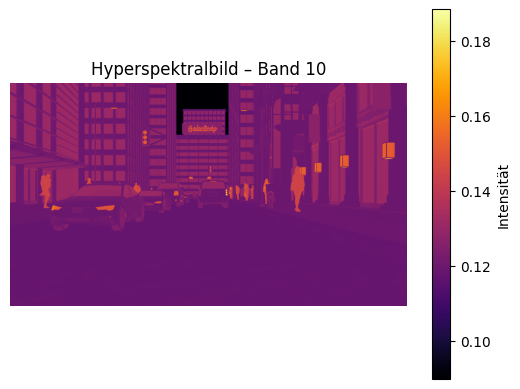

In [67]:
import matplotlib.pyplot as plt

band_index = 10  # z. B. Band 11
plt.imshow(S[:, :, band_index], cmap='inferno')
plt.title(f"Hyperspektralbild – Band {band_index}")
plt.colorbar(label="Intensität")
plt.axis('off')
plt.show()

### Durchschnitt über alle 54 Bänder (Graustufenübersicht)

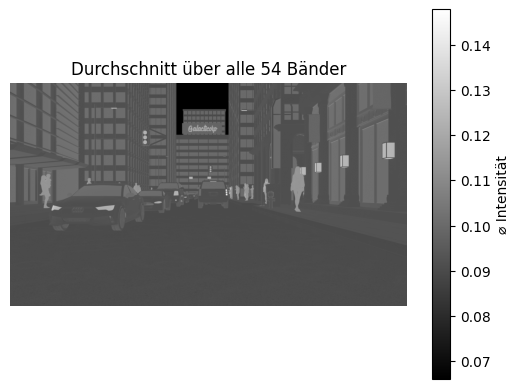

In [68]:
S_mean = S.mean(axis=2)

plt.imshow(S_mean, cmap='gray')
plt.title("Durchschnitt über alle 54 Bänder")
plt.colorbar(label="⌀ Intensität")
plt.axis('off')
plt.show()

### Spektrum eines bestimmten Pixels anzeigen

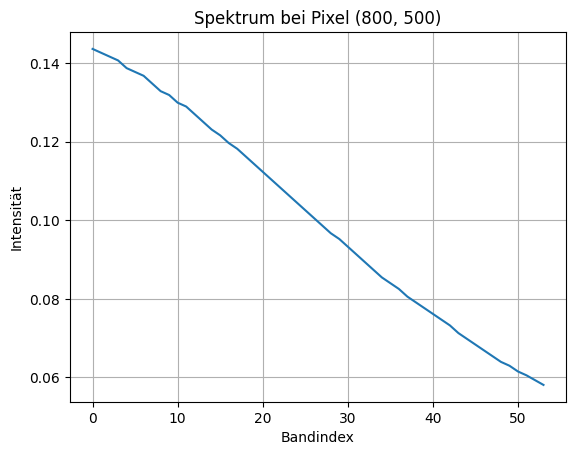

In [69]:
# Der Verlauf ist monoton fallend, d. h. das Material reflektiert 
# (oder emittiert) im ersten Band mehr als im letzten → evtl. wasserhaltiges oder absorbierendes Material.

y, x = 500, 800  # Beispielkoordinate (Reihe, Spalte)
spectrum = S[y, x, :]  # Vektor mit 54 Werten

plt.plot(spectrum)
plt.title(f"Spektrum bei Pixel ({x}, {y})")
plt.xlabel("Bandindex")
plt.ylabel("Intensität")
plt.grid(True)
plt.show()

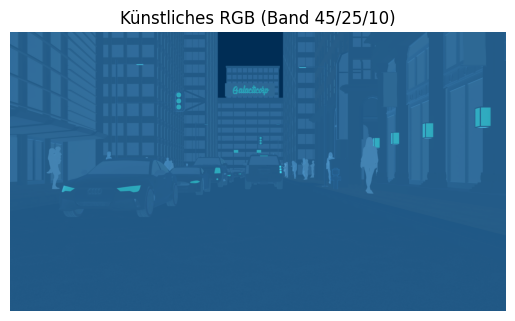

In [70]:
rgb_fake = np.stack([S[:, :, 45], S[:, :, 25], S[:, :, 10]], axis=2)
rgb_fake = (rgb_fake - rgb_fake.min()) / (rgb_fake.max() - rgb_fake.min()) * 255
rgb_fake = rgb_fake.astype(np.uint8)

plt.imshow(rgb_fake)
plt.title("Künstliches RGB (Band 45/25/10)")
plt.axis('off')
plt.show()

In [72]:
import scipy.io

# Datei laden
data = scipy.io.loadmat("hadar_ground.mat")

# Alle enthaltenen Variablennamen anzeigen

print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'depth'])


### So analysierst du depth

In [73]:
depth = data['depth']

print("Shape:", depth.shape)
print("Dtype:", depth.dtype)
print("Min:", depth.min(), "Max:", depth.max())

Shape: (1080, 1920)
Dtype: float32
Min: 4.679143 Max: 472.66153


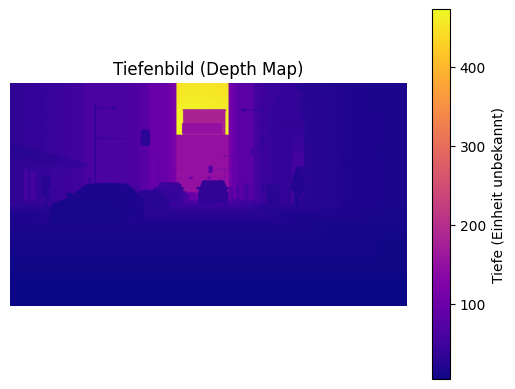

In [74]:
import matplotlib.pyplot as plt

plt.imshow(depth, cmap='plasma')  # oder cmap='viridis', 'inferno'
plt.title("Tiefenbild (Depth Map)")
plt.colorbar(label="Tiefe (Einheit unbekannt)")
plt.axis('off')
plt.show()

## Was trainierst du konkret?

Du hast folgende Daten:

$$
S \in \mathbb{R}^{H \times W \times 54}
$$

> Hyperspektralwürfel mit einem Spektrum (54 Kanäle) pro Pixel

$$
\text{depth} \in \mathbb{R}^{H \times W}
$$

> Ground-Truth-Tiefenbild (z. B. per LiDAR oder Time-of-Flight-Kamera)

---

### Ziel:

Du trainierst ein Modell

$$
\hat{D} = f_\theta(S)
$$

das für jedes Pixel aus dem Spektrum \( S \) die Tiefe \( \hat{D} \) schätzt.

---

### Trainingsziel: Minimierung des Fehlers

Du verwendest die Ground-Truth-Tiefe zur Definition eines **mittleren quadratischen Fehlers (MSE)**:

$$
\text{Loss} = \frac{1}{H \cdot W} \sum_{i,j} \left( \hat{D}_{i,j} - \text{depth}_{i,j} \right)^2
$$

---

## Warum ist das spannend?

Weil du mit spektralen Informationen **berührungslos** auf **3D-Geometrie** schließen kannst – ideal für Anwendungen wie:

- **Landwirtschaft**: z. B. Pflanzenhöhe aus spektraler Reflexion  
- **Fernerkundung**: z. B. Gebäudehöhen aus Hyperspektraldaten  
- **Medizin**: z. B. Gewebetiefe aus thermischer/emittierter Strahlung  
- **Verteidigung**: z. B. Distanzbestimmung durch Rauch, Nebel oder Tarnung


Depth = Abstand vom Objekt zur Kamera (in Metern, Millimetern, oder Normiert).
Du kannst diese Werte also z. B. für Trainingslabels nehmen, um ein ML-Modell zu bauen, das „aus Lichtentstehung und Reflexion“ (Spektralinformation) auf Tiefe schließt.

## ICVL Hyperspectral Dataset (Israel Institute of Technology)

In [87]:
import scipy.io

# Datei laden
data = scipy.io.loadmat("sample_hs_im.mat")

# Alle enthaltenen Variablennamen anzeigen

print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'bands', 'rad', 'rgb'])


In [88]:
# Wahrscheinlich ein Hyperspektralbild mit 54 Spektralbändern (z. B. Reflektanz oder Strahlung) pro Pixel

import numpy as np

rad = data['rad']
print("Shape:", rad.shape)
print("Dtype:", rad.dtype)
print("Min:", rad.min(), "Max:", rad.max())

Shape: (1392, 1300, 31)
Dtype: float64
Min: 186.5 Max: 2672.75


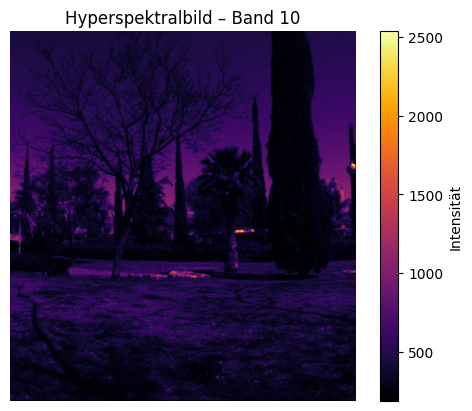

In [89]:
import matplotlib.pyplot as plt

band_index = 10  # z. B. Band 11
plt.imshow(rad[:, :, band_index], cmap='inferno')
plt.title(f"Hyperspektralbild – Band {band_index}")
plt.colorbar(label="Intensität")
plt.axis('off')
plt.show()

In [94]:
rgb = data["rgb"]
rgb.shape

(1392, 1308, 3)

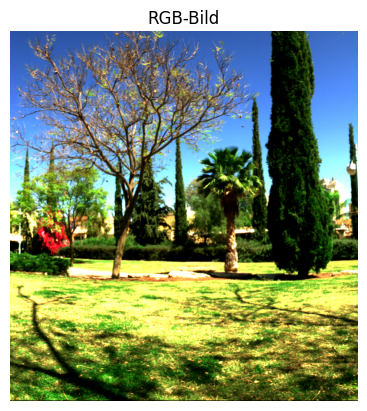

In [96]:


plt.imshow(rgb)  # Falls rgb ursprünglich (3, H, W) ist
plt.title("RGB-Bild")
plt.axis('off')
plt.show()

In [40]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Datei laden
with h5py.File("4cam_0411-1648.mat", "r") as f:
    print(list(f.keys()))
    
    # Wellenlängen
    bands = f['bands'][:]
    
    # Radiometrisches Wärmebild
    rad = f['rad'][:]  # z. B. (256, 320, 40)
    
    # RGB-Bild
    rgb = f['rgb'][:]  # z. B. (256, 320, 3)

# Typ und Form anzeigen
print("Bands:", bands.shape)
print("rad shape:", rad.shape)
print("rgb shape:", rgb.shape)

['bands', 'rad', 'rgb']
Bands: (31, 1)
rad shape: (31, 1392, 1300)
rgb shape: (3, 1306, 1392)


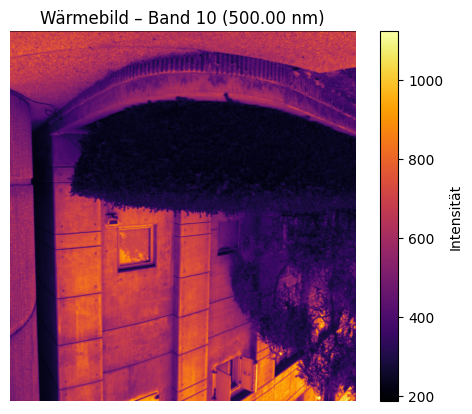

In [49]:
import matplotlib.pyplot as plt

band_index = 10  # z. B. Band 11
wavelength = float(bands[band_index][0])  # <- extrahiere den Float-Wert

plt.imshow(rad[band_index, :, :], cmap='inferno')  # rad ist (31, H, W)
plt.title(f"Wärmebild – Band {band_index} ({wavelength:.2f} nm)")
plt.colorbar(label='Intensität')
plt.axis('off')
plt.show()



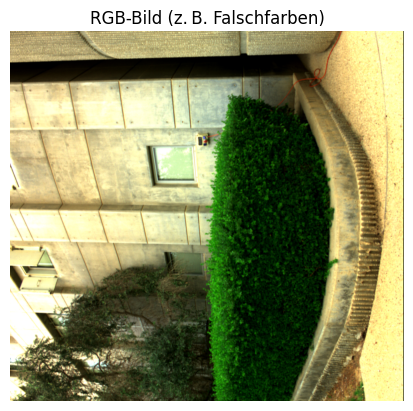

In [45]:
plt.imshow(np.transpose(rgb, (1, 2, 0)))  # Falls rgb ursprünglich (3, H, W) ist
plt.title("RGB-Bild (z. B. Falschfarben)")
plt.axis('off')
plt.show()

In [43]:
print(bands.shape)
print(type(bands[band_index]))
print(bands[band_index])


(31, 1)
<class 'numpy.ndarray'>
[500.]


## Empfehlung:

    Immer zuerst data.keys() aufrufen

    Dann data[key].shape, dtype und ggf. min / max prüfen

    Wenn du dir unsicher bist: Visualisiere ein Band oder das Mittelbild

## Universelle Ladefunktion für .mat-Dateien

In [76]:
import scipy.io
import numpy as np

def load_hyperspectral_mat(path):
    """
    Universelle Ladefunktion für .mat-Dateien mit Hyperspektraldaten, RGB, Labels oder Tiefe.

    Gibt ein Dictionary mit klar benannten Komponenten zurück (falls vorhanden).
    """
    data = scipy.io.loadmat(path)
    result = {}

    # Entferne MATLAB-interne Keys
    keys = [k for k in data.keys() if not k.startswith("__")]

    for key in keys:
        value = data[key]
        shape = value.shape

        # RGB? meist 3-Kanal und kleiner als Spektraldaten
        if len(shape) == 3 and shape[0] == 3:
            result['rgb'] = np.transpose(value, (1, 2, 0)).astype(np.uint8)

        # Hyperspektralwürfel (z. B. (H, W, B) oder (B, H, W))
        elif len(shape) == 3:
            if shape[2] > 10:  # (H, W, B) → direkt nutzbar
                result['spectral_cube'] = value
            elif shape[0] > 10:  # (B, H, W) → transponieren
                result['spectral_cube'] = np.transpose(value, (1, 2, 0))

        # Labelbild (2D)
        elif len(shape) == 2 and np.issubdtype(value.dtype, np.integer):
            result['labels'] = value.astype(int)

        # Tiefe (2D float, oft metrisch)
        elif len(shape) == 2 and np.issubdtype(value.dtype, np.floating):
            result['depth'] = value

        # 1D-Liste → Wellenlängen?
        elif len(shape) == 2 and (shape[1] == 1 or shape[0] == 1):
            result['wavelengths'] = value.flatten()

        # Sonst einfach mit Key merken
        else:
            result[key] = value

    return result


Hyperspektraldaten Shape: (1308, 3, 1392)


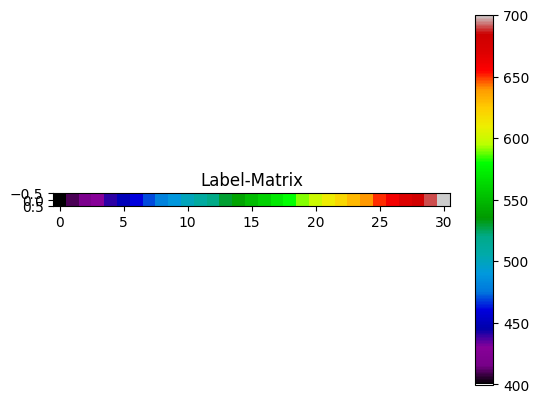

In [77]:
data = load_hyperspectral_mat("sample_hs_im.mat")

if 'spectral_cube' in data:
    print("Hyperspektraldaten Shape:", data['spectral_cube'].shape)

if 'rgb' in data:
    import matplotlib.pyplot as plt
    plt.imshow(data['rgb'])
    plt.title("RGB Bild")
    plt.axis('off')
    plt.show()

if 'labels' in data:
    plt.imshow(data['labels'], cmap='nipy_spectral')
    plt.title("Label-Matrix")
    plt.colorbar()
    plt.show()
